In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [2]:
train= pd.read_csv("./datasets/train - pre_scaled.csv")
target= pd.read_csv("./datasets/target - pre_scaled.csv")
test= pd.read_csv("./datasets/test - pre_scaled.csv")

In [3]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 42)

In [4]:
preprocessor = pickle.load(open('./models/preprocessor.pkl', 'rb'))
target_scaler = pickle.load(open('./models/target_scaler.pkl', 'rb'))

# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer
# from sklearn.compose import ColumnTransformer


# outlier_cols = ['Item_Visibility']
# id_cols = ['Item_Identifier', 'Outlet_Identifier']
# cont_cols = ['Item_Weight', 'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Age']
# binary_cols = ['Item_Fat_Content_NA', 'Item_Fat_Content_Regular',
#        'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
#        'Item_Type_Dairy', 'Item_Type_Frozen Foods',
#        'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
#        'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
#        'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
#        'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
#        'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
#        'Outlet_Type_Supermarket Type3']


# preprocessor = ColumnTransformer([
#     ('yeo-johnson', PowerTransformer(method = 'yeo-johnson'), outlier_cols),
#     # ('standard_scaler', StandardScaler(), id_cols + cont_cols),
#     ('passthrough', 'passthrough', binary_cols + id_cols + cont_cols)
# ])


X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)

y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)

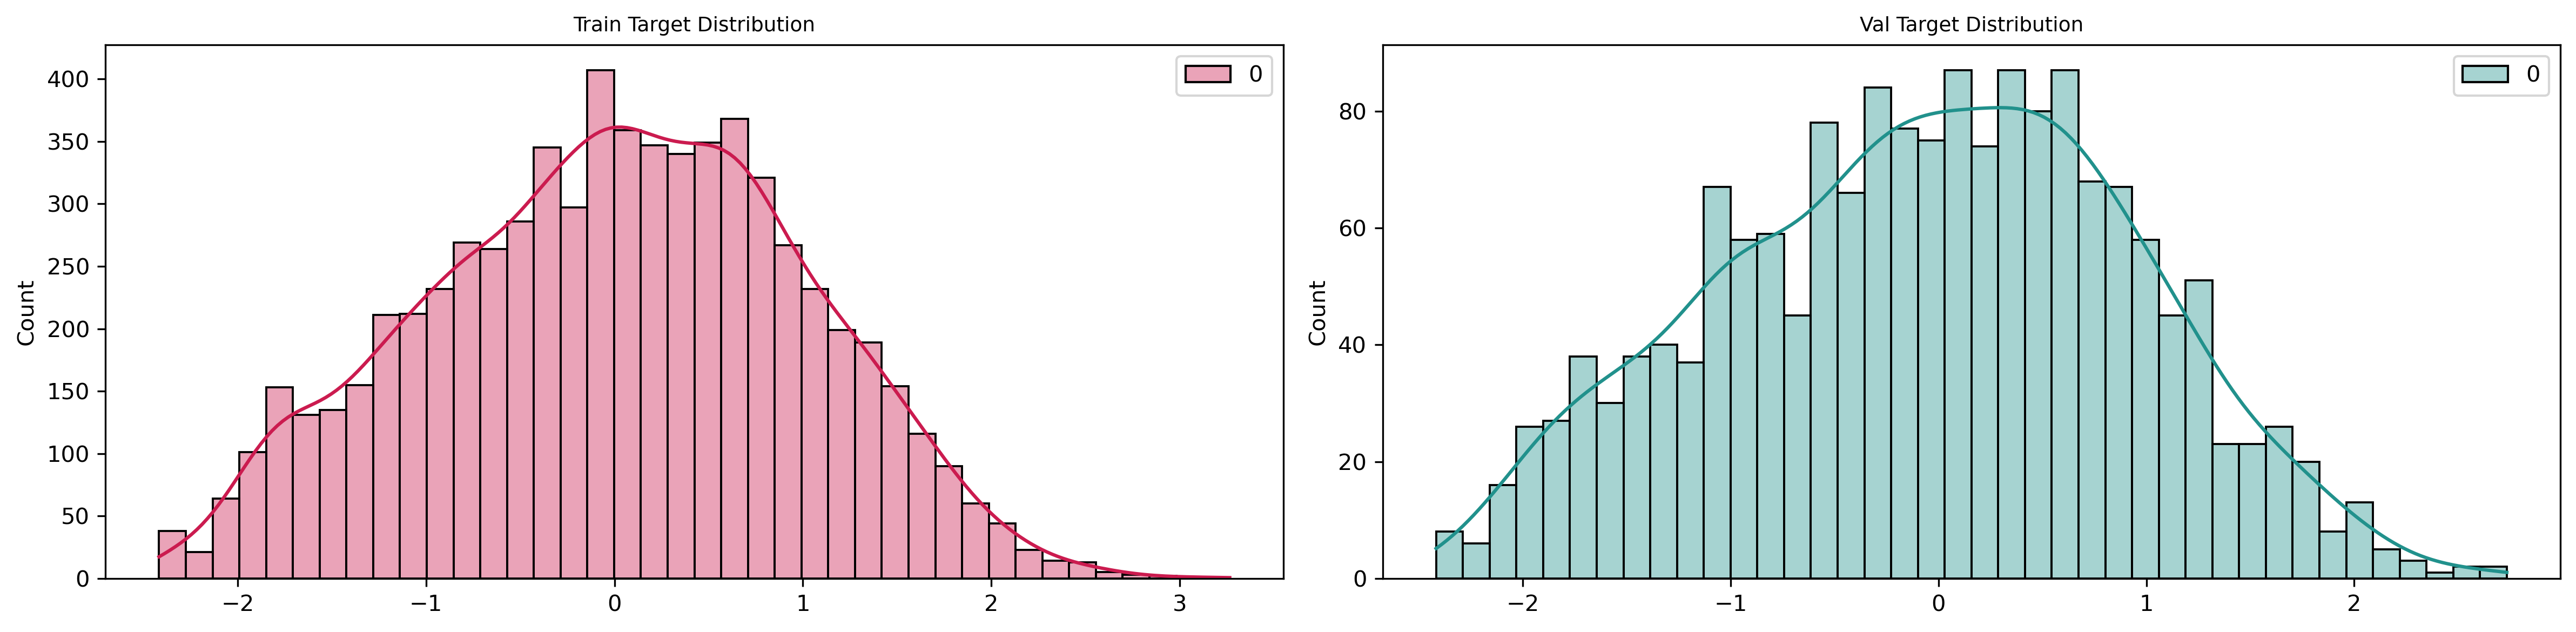

In [5]:
# Check Target Distribution - for no skewness

plt.figure(figsize = (16,4), dpi = 300)
plt.subplot(1,2,1)
sns.histplot(y_train_scaled, kde = True, bins = 40, alpha = 0.4, palette='rocket')
plt.title("Train Target Distribution", fontsize = 9)


plt.subplot(1,2,2)
sns.histplot(y_val_scaled, kde = True, bins = 40, alpha = 0.4, palette='viridis')
plt.title("Val Target Distribution", fontsize = 9)

plt.tight_layout()
plt.show()

In [6]:
def evaluate_model(y_true, y_pred):
    y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
    y_true_orig = target_scaler.inverse_transform(y_true.reshape(-1,1)).ravel()

    rmse = root_mean_squared_error(y_true_orig, y_pred_orig)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true, y_pred)
    print(f"""RMSE: {rmse}
MAE: {mae}
R2: {r2}""")

## **Linear Regression**

In [9]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)

y_pred = lr.predict(X_val_scaled)
print("*"*10, "Base Linear Regression Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)

********** Base Linear Regression Results ********** 

RMSE: 1042.807049180227
MAE: 725.3346397934525
R2: 0.6940411887390396


## **Elastic Net Regression**

In [52]:
en = ElasticNet(random_state = 42)
en.fit(X_train_scaled, y_train_scaled)

y_pred = en.predict(X_val_scaled)
print("*"*10, "Base ElasticNet Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)
print("\n")

# Hyperparameter Tuning using GridSearchCV

en_grid_params = {
    'alpha': np.linspace(0.1, 10, 40),
    'l1_ratio': np.linspace(0.1, 1, 30)
}
en_grid = GridSearchCV(
    en,
    en_grid_params,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    verbose = 1
)
en_grid.fit(X_train_scaled, y_train_scaled)
y_pred = en_grid.predict(X_val_scaled)
print("*"*10, "Tuned ElasticNet Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)
#print("\n")
print("Best Hyperparameters: ", en_grid.best_params_)

********** Base ElasticNet Results ********** 

RMSE: 1373.5233335683135
MAE: 998.9480244106647
R2: 0.32693742749077015


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
********** Tuned ElasticNet Results ********** 

RMSE: 1191.8699880343463
MAE: 845.5006543886998
R2: 0.573619297010578
Best Hyperparameters:  {'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.1)}


* Elastic Net is trying to close down alpha and making it more like a linear regression. This won't help

## **Random Forest**

In [96]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train_scaled, y_train_scaled)

y_pred = rf.predict(X_val_scaled)
print("*"*10, "Base Random Forest Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)
print("\n")

# Hyperparameter Tuning using GridSearchCV

# rf_grid_params = {
#     'n_estimators': [200, 300, 400, 500],  # Expand around 200
#     'max_depth': [10, 12, 15, 18, 20, 25],  # Go deeper than current 10
#     'min_samples_split': [5, 10, 15, 20],  # Around current 10
#     'min_samples_leaf': [1, 2, 3, 4, 5],   # Around current 2
#     'max_features': ['sqrt', 'log2', 0.5, 0.7],  # Add feature sampling control
#     'bootstrap': [True],  # Keep True for now
# }

# rf_grid = GridSearchCV(
#     rf,
#     rf_grid_params,
#     cv = 3,
#     scoring = 'neg_root_mean_squared_error',
#     n_jobs = -1,
#     verbose = 1
# )
# rf_grid.fit(X_train_scaled, y_train_scaled)
# y_pred = rf_grid.predict(X_val_scaled)
# print("*"*10, "Tuned ElasticNet Results", "*"*10, "\n")
# evaluate_model(y_val_scaled, y_pred)
# print("Best Hyperparameters: ", rf_grid.best_params_)

********** Base Random Forest Results ********** 

RMSE: 1102.1399570516862
MAE: 760.7188622196225
R2: 0.6732667393702898




In [ ]:
rf_random_params = {
    'n_estimators': [200, 300, 400, 500],  # Expand around 200
    'max_depth': [10, 12, 15, 18, 20, 25],  # Go deeper than current 10
    'min_samples_split': [5, 10, 15, 20],  # Around current 10
    'min_samples_leaf': [1, 2, 3, 4, 5],   # Around current 2
    'max_features': ['sqrt', 'log2', 0.5, 0.7],  # Add feature sampling control
    'bootstrap': [True],  # Keep True for now
}

rf_random = RandomizedSearchCV(
    rf,
    rf_random_params,
    n_iter=50,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rf_random.fit(X_train_scaled, y_train_scaled)
y_pred = rf_random.predict(X_val_scaled)
print("*"*10, "RandomizedSearchCV Random Forest Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)
print("Best Hyperparameters: ", rf_random.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

********** RandomizedSearchCV Random Forest Results ********** 

RMSE: 2728.416239524354
MAE: 2484.309463256159
R2: 0.7073089215741153
Best Hyperparameters:  {'n_estimators': 400, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 12, 'bootstrap': True}


In [ ]:
# Train a new RandomForestRegressor with the best hyperparameters from rf_random
rf_best = RandomForestRegressor(random_state=42, **rf_random.best_params_)
rf_best.fit(X_train_scaled, y_train_scaled)

y_pred = rf_best.predict(X_val_scaled)
print("*"*10, "Random Forest (Best Params) Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)

********** Random Forest (Best Params) Results ********** 

RMSE: 1033.9792343673728
MAE: 712.1966829686622
R2: 0.7073089215741153


In [55]:
# Train a new RandomForestRegressor with the best hyperparameters from rf_random
rf_best = RandomForestRegressor(random_state=42, **rf_random.best_params_)
rf_best.fit(X_train_scaled, y_train_scaled)

y_pred = rf_best.predict(X_val_scaled)
print("*"*10, "Random Forest (Best Params) Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)

********** Random Forest (Best Params) Results ********** 

RMSE: 1031.7070926311235
MAE: 711.2129200490165
R2: 0.7080335747387456


In [99]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.7
)
xgb_model.fit(X_train_scaled, y_train_scaled)
y_pred = xgb_model.predict(X_val_scaled)
print("*"*10, "XGBoost Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)

********** XGBoost Results ********** 

RMSE: 1050.5485644945575
MAE: 718.5892563360367
R2: 0.7045056491700953


In [ ]:
from catboost import CatBoostRegressor

cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100
}


cat = CatBoostRegressor(**cat_params)
cat.fit(X_train_scaled, y_train_scaled, eval_set=(X_val_scaled, y_val_scaled), early_stopping_rounds=50)

y_pred = cat.predict(X_val_scaled)
print("*"*10, "CatBoostRegressor Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)

0:	learn: 0.9674105	test: 0.9623807	best: 0.9623807 (0)	total: 3.25ms	remaining: 3.25s
100:	learn: 0.5424750	test: 0.5340870	best: 0.5340870 (100)	total: 68.4ms	remaining: 609ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5338747652
bestIteration = 122

Shrink model to first 123 iterations.
********** CatBoostRegressor Results ********** 

RMSE: 1030.5458077527144
MAE: 710.4650099371038
R2: 0.7111765142691857


In [108]:
best_cat_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 4,
    'l2_leaf_reg': 3,
    'border_count': 64,
    'verbose' : 0,
    'loss_function': 'RMSE'
    }
best_cat = CatBoostRegressor(**best_cat_params)
best_cat.fit(X_train_scaled, y_train_scaled, eval_set=(X_val_scaled, y_val_scaled), early_stopping_rounds=50)

y_pred = best_cat.predict(X_val_scaled)
print("*"*10, "best_CatBoostRegressor Results", "*"*10, "\n")
evaluate_model(y_val_scaled, y_pred)

********** best_CatBoostRegressor Results ********** 

RMSE: 1027.6693493128755
MAE: 710.0803316897521
R2: 0.7112744611914814


In [138]:
# Best CatBoost - Feature Importance

pd.DataFrame(best_cat.get_feature_importance(), index = train.columns, columns=['importance']).sort_values(['importance'], ascending=False)

,importance
Outlet_Identifier,34.110717
Item_Visibility,23.539087
Outlet_Age,15.533101
Outlet_Type_Supermarket Type3,11.367900
Outlet_Location_Type,6.019138
Outlet_Type_Supermarket Type1,4.586225
Outlet_Size,4.012727
Item_Identifier,0.280612
Item_MRP,0.241419
Item_Weight,0.145698


* Outlet_Identifier -> It has too much reliance. Keep for now.
* Item_Visibility -> Does good. Leave as it is for now. For refining add normalised version w.r.t Item_Identifier
* Outlet_Age <> Outlet_Type -> Too distributed, try to create a compound feature to capture everything in a smaller variable.
* Item_Identifier -> Low Importance, Possibly because of high cardinality. Create Item_Category like you were thinking in the beginning.
* Item_MRP -> Not convincing given the domain, Create banding and try out.
* Item_Type & Item_Fat_Content -> Very Low and adds ineffective. Scratch OHE and do label encoding.

**Note -**
* Since, CAT Boost yielded best results skip the encoding part and pass it to CAT directly as categorical features if training on CAT

In [93]:
test_scaled = preprocessor.transform(test)
test_pred = cat.predict(test_scaled)
test_pred_orig = target_scaler.inverse_transform(test_pred.reshape(-1,1)).ravel()

In [ ]:
import joblib

# Load encoders
le_dict = joblib.load("./models/label_encoders.pkl")

def submission_file(test_pred_orig):
    submission = test[['Item_Identifier', 'Outlet_Identifier']]
    submission['Item_Outlet_Sales'] = test_pred_orig

    submission['Item_Identifier'] = le_dict['Item_Identifier'].inverse_transform(submission['Item_Identifier'])
    submission['Outlet_Identifier'] = le_dict['Outlet_Identifier'].inverse_transform(submission['Outlet_Identifier'])

    submission.to_csv('./datasetst/final_submission.csv', index = False)
    return submission

submission_file(test_pred_orig)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1470.882845
1,FDW14,OUT017,1359.726756
2,NCN55,OUT010,582.468148
3,FDQ58,OUT017,2389.967199
4,FDY38,OUT027,5750.468868
...,...,...,...
5676,FDB58,OUT046,2059.444665
5677,FDD47,OUT018,2353.157859
5678,NCO17,OUT045,1832.821288
5679,FDJ26,OUT017,3337.984495


In [19]:
train= pd.read_csv("./data-phase2/train.csv")
test= pd.read_csv("./data-phase2/test.csv")
target = train['Item_Outlet_Sales']
train.drop(['Item_Outlet_Sales'], axis = 1, inplace = True)

train.fillna('Not Applicable', inplace = True)
cat_features = list(train.select_dtypes(exclude = np.number).columns)

X_train, X_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 42)

def evaluate_model(y_true, y_pred, print_res = True, scaled = True):
    if scaled:
        y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
        y_true_orig = target_scaler.inverse_transform(y_true.reshape(-1,1)).ravel()
    
        rmse = root_mean_squared_error(y_true_orig, y_pred_orig)
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        r2 = r2_score(y_true, y_pred)
        if print_res:
            print(f"""RMSE: {rmse}\nMAE: {mae}\nR2: {r2}""")
        return rmse, mae, r2
    else:
        rmse = root_mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        if print_res:
            print(f"""RMSE: {rmse}\nMAE: {mae}\nR2: {r2}""")
        return rmse, mae, r2

from catboost import CatBoostRegressor, Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

cat_params = {
    'iterations': 300,
    'learning_rate': 0.01,
    'depth': 8,
    'l2_leaf_reg': 3,
    'border_count': 256,
    'verbose' : 0,
    'loss_function': 'RMSE'
    }

cat = CatBoostRegressor(**cat_params)#, task_type='GPU')
cat.fit(train_pool, eval_set=val_pool, verbose=100)

y_pred = cat.predict(X_val)
print("*"*10, "best_CatBoostRegressor Results", "*"*10, "\n")
evaluate_model(y_val, y_pred, scaled = False)

0:	learn: 1710.7929681	test: 1642.7281290	best: 1642.7281290 (0)	total: 2.69ms	remaining: 804ms
100:	learn: 1214.7769384	test: 1143.2057314	best: 1143.2057314 (100)	total: 317ms	remaining: 624ms
200:	learn: 1107.8238899	test: 1039.9945608	best: 1039.9945608 (200)	total: 637ms	remaining: 314ms
299:	learn: 1081.9022111	test: 1021.2366129	best: 1021.2366129 (299)	total: 997ms	remaining: 0us

bestTest = 1021.236613
bestIteration = 299

********** best_CatBoostRegressor Results ********** 

RMSE: 1021.2366105505932
MAE: 725.1368409931829
R2: 0.616285614202118


(1021.2366105505932, 725.1368409931829, 0.616285614202118)

In [20]:
train

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Age
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,FDA,26
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,DRC,16
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,FDN,26
3,19.200,Regular,0.089689,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,FDX,27
4,8.930,Not App,0.039236,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,NCD,38
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,High,Tier 3,Supermarket Type1,FDF,38
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,Small,Tier 2,Supermarket Type1,FDS,23
8520,10.600,Not App,0.035186,Health and Hygiene,85.1224,OUT035,Small,Tier 2,Supermarket Type1,NCJ,21
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,Medium,Tier 3,Supermarket Type2,FDN,16


In [15]:
pd.DataFrame(cat.get_feature_importance(), index = train.columns, columns=['importance']).sort_values(['importance'], ascending=False)

,importance
Item_MRP_bands,40.519924
Outlet_Context,26.219846
Outlet_Identifier,21.829390
Outlet_Age,4.313684
Item_Fat_Content,3.768618
Item_Type,1.371727
Item_Category,1.043560
Item_Weight,0.541557
Item_Visibility,0.391693


# **Final Model**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [22]:
train= pd.read_csv("./data-phase2/train.csv")
test= pd.read_csv("./data-phase2/test.csv")

In [23]:
target = train['Item_Outlet_Sales']
train.drop(['Item_Outlet_Sales'], axis = 1, inplace = True)

In [24]:
cat_features = list(train.select_dtypes(exclude = np.number).columns)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 42)

In [26]:
def evaluate_model(y_true, y_pred, print_res = True, scaled = True):
    if scaled:
        y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
        y_true_orig = target_scaler.inverse_transform(y_true.reshape(-1,1)).ravel()
    
        rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        r2 = r2_score(y_true, y_pred)
        if print_res:
            print(f"""RMSE: {rmse}\nMAE: {mae}\nR2: {r2}""")
        return rmse, mae, r2
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        if print_res:
            print(f"""RMSE: {rmse}\nMAE: {mae}\nR2: {r2}""")
        return rmse, mae, r2

In [ ]:
import time
import itertools


param_grid = {
    'iterations': [100, 500, 1000, 1500],
    'learning_rate': np.linspace(0.01, 0.1, 5),
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
}

keys = list(param_grid.keys())
values = list(param_grid.values())
combinations = list(itertools.product(*values))

print(f"Total combinations to test: {len(combinations)}")
print("="*70)

start_time = time.time()
results = []
best_rmse = float('inf')
best_params = None
best_model = None

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

for i, combo in enumerate(combinations):
    params = dict(zip(keys, combo))
    
    
    # Train model with current params
    model = CatBoostRegressor(
        **params,
        random_seed=42,
        loss_function='RMSE',
        task_type='GPU',
        verbose=0
    )
    

    model.fit(train_pool, eval_set=val_pool, verbose=False)
    
    y_pred = model.predict(X_val)
    rmse, mae, r2 = evaluate_model(y_val, y_pred, print_res = False, scaled = False)

    
    results.append({
        'params': params,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'iterations': params['iterations'],
        'learning_rate': params['learning_rate'],
        'depth': params['depth'],
        'l2_leaf_reg': params['l2_leaf_reg'],
        'border_count': params['border_count']
    })
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_model = model
        print(f"\n!!! [{i+1}/{len(combinations)}] New Best RMSE: {rmse:.2f}")
        print(f"   Parameters: {params}")
    
    # Progress update every 20 combinations
    if (i + 1) % 20 == 0:
        elapsed = (time.time() - start_time) / 60
        print(f"Progress: {i+1}/{len(combinations)} ({elapsed:.1f} min elapsed)")


print("\n" + "="*70)
print("SEARCH COMPLETED")
print("="*70)
print(f"\nBest Validation RMSE: {best_rmse:.2f}")
print(f"Best Parameters: {best_params}")

* Best Validation RMSE: 1012.34
* Best Parameters: {'iterations': 500, 'learning_rate': 0.0775, 'depth': 8, 'l2_leaf_reg': 3, 'border_count': 64}

In [ ]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

best_cat_params = {
    'iterations': 500,
    'learning_rate': 0.01,#0.0775,
    'depth': 8,
    'l2_leaf_reg': 3,
    'border_count': 64,
    'verbose' : 0,
    'loss_function': 'RMSE'
    }

best_cat = CatBoostRegressor(**best_cat_params, task_type='GPU')
best_cat.fit(train_pool, eval_set=val_pool, verbose=100)

y_pred = best_cat.predict(X_val)
print("*"*10, "best_CatBoostRegressor Results", "*"*10, "\n")
evaluate_model(y_val, y_pred, print_res = True, scaled = False)

0:	learn: 1710.6542052	test: 1642.8163775	best: 1642.8163775 (0)	total: 4.14ms	remaining: 2.06s
100:	learn: 1216.8010177	test: 1144.0654532	best: 1144.0654532 (100)	total: 307ms	remaining: 1.21s
200:	learn: 1108.1699031	test: 1038.9594369	best: 1038.9594369 (200)	total: 628ms	remaining: 934ms
300:	learn: 1080.9427705	test: 1019.4011441	best: 1019.4011441 (300)	total: 963ms	remaining: 637ms
400:	learn: 1069.5534358	test: 1015.1251550	best: 1015.1229730 (399)	total: 1.31s	remaining: 323ms
499:	learn: 1060.8034174	test: 1014.1320062	best: 1014.1320062 (499)	total: 1.62s	remaining: 0us

bestTest = 1014.132006
bestIteration = 499

********** best_CatBoostRegressor Results ********** 

RMSE: 1014.1320038397979
MAE: 712.1152832842664
R2: 0.6216059426687005


(np.float64(1014.1320038397979), 712.1152832842664, 0.6216059426687005)

In [29]:
final_preds = best_cat.predict(test)
final_preds

array([1739.39654675, 1378.54678246,  632.70270869, ..., 1950.96865936,
       3509.47026783, 1255.82548525])

In [32]:
pickle.dump(best_cat, open('./models/final_cat_boost_predictor.pkl', 'wb'))

In [31]:
import joblib

# Load encoders
le_dict = joblib.load("./models/label_encoders.pkl")


def submission_file(test_pred_orig):
    cols_test = pd.read_csv("./datasets/test - pre_scaled.csv")
    submission = cols_test[['Item_Identifier', 'Outlet_Identifier']]
    submission['Item_Outlet_Sales'] = test_pred_orig

    submission['Item_Identifier'] = le_dict['Item_Identifier'].inverse_transform(submission['Item_Identifier'])
    submission['Outlet_Identifier'] = le_dict['Outlet_Identifier'].inverse_transform(submission['Outlet_Identifier'])

    submission.to_csv('final_submission.csv', index = False)
    return submission

submission_file(final_preds)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1739.396547
1,FDW14,OUT017,1378.546782
2,NCN55,OUT010,632.702709
3,FDQ58,OUT017,2528.085739
4,FDY38,OUT027,5988.719048
...,...,...,...
5676,FDB58,OUT046,2221.235729
5677,FDD47,OUT018,2571.938635
5678,NCO17,OUT045,1950.968659
5679,FDJ26,OUT017,3509.470268
